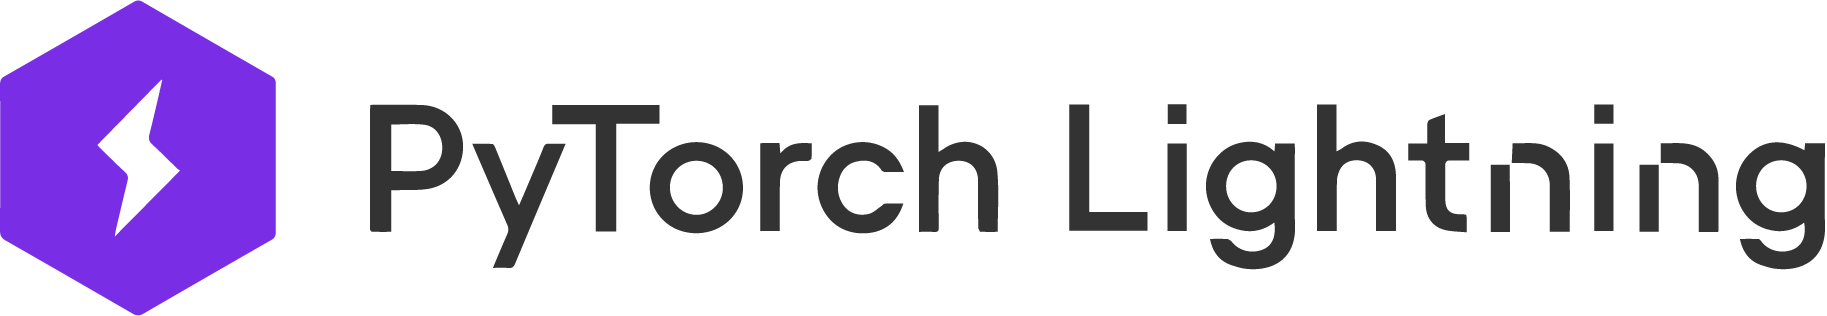

In [22]:
%%capture

!apt-get update && apt-get install -y xvfb
!pip install swig
!pip install gym[box2d]==0.23.1 pytorch-lightning==1.6.0 pyvirtualdisplay

In [23]:
!pip install box2d pygame

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 22.8 MB/s eta 0:00:00


In [11]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.7/931.7 kB 47.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [8]:
!pip install pyvirtualdisplay

#### Setup virtual display

In [9]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [12]:
import copy
import gym
import torch

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [13]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the Deep Q-Network

In [14]:
class DQN(nn.Module):
    def __init__(self, hidden_size, obs_size, n_actions): # hs -> number of units in the hidden layers, obs -> features of states
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(obs_size, hidden_size), # input, output
        nn.ReLU,
        nn.Linear(hidden_size, hidden_size), # input, output
        nn.ReLU,
        nn.Linear(hidden_size, n_actions) # input, output
        )

    def forward(self, x): # x is a tensor of values
        return self.net(x.float())

#### Create the policy

In [15]:
def epsilon_greedy(state, env, net, epsilon=0.0):
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        state = torch.tensor([state]).to(device)
        q_values = net(state)
        _, action = torch.max(q_values, dim=1)
        action = int(action.item())
    return action

#### Create the replay buffer

In [16]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

In [17]:
class RLDataset(IterableDataset):
    def __init__(self, buffer, sample_size=200):
        self.buffer = buffer
        self.sample_size = sample_size

    def __iter__(self):
        for experience in self.buffer.sample(self.sample_size):
            yield experience

#### Create the environment

In [37]:
def create_environment(name):
    env = gym.make(name)
    env = RecordVideo(env, video_folder='./videos')
    return env

In [39]:
env = create_environment('LunarLander-v2')

for episode in range(10):
  done = False
  env.reset()
  while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for enviro

In [40]:
display_video(episode=8)

#### Create the test/sampling function

#### Create the Deep Q-Learning algorithm

#### Purge logs and run the visualization tool (Tensorboard)

#### Train the policy

#### Check the resulting policy